In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Dataset**
Link: https://www.kaggle.com/datasets/waalbannyantudre/hate-speech-detection-curated-dataset/data

The dataset consisted of multiple languages at the very begining, but we cleaned it and managed to keep it in English

The final Dataset after cleaning is: **finalbalanced.csv**

In [2]:
!pip install pandas numpy scikit-learn matplotlib seaborn
!pip install wordcloud matplotlib

In [3]:
import pandas as pd

# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/HateSpeech/finalbalanced.csv')
df.rename(columns={'Content': 'tweet', 'Label': 'label'}, inplace=True)
df.head()

,tweet,label
0,denial of normal the con be asked to comment o...,1
1,just by being able to tweet this insufferable ...,1
2,that is retarded you too cute to be single tha...,1
3,thought of a real badass mongol style declarat...,1
4,afro american basho,1


# **EDA (Exploratory Data Analysis)**

Here we gather information about data

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 714139 entries, 0 to 714138
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   tweet   714139 non-null  object
 1   label   714139 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 10.9+ MB


In [5]:
# Check the value counts
print(df['label'].value_counts())

label
0    361594
1    352545
Name: count, dtype: int64


In [6]:
import re
import string
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Only need to do these once
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt_tab')

# Initialize tools
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Your clean_text function
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'<.*?>+', '', text)
    text = re.sub(f"[{re.escape(string.punctuation)}]", '', text)
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'\w*\d\w*', '', text)

    # Normalize smart quotes
    text = text.replace('“', '').replace('”', '').replace("’", "'").replace("‘", "'")

    # Remove possessive 's
    text = re.sub(r"'s\b", '', text)

    # Tokenize and lemmatize
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and len(word) > 2]

    return ' '.join(tokens)

# Apply to 'tweet' column
df['clean_text'] = df['tweet'].apply(clean_text)

# Preview result
df[['tweet', 'clean_text']].head()


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


,tweet,clean_text
0,denial of normal the con be asked to comment o...,denial normal con asked comment tragedy emotio...
1,just by being able to tweet this insufferable ...,able tweet insufferable bullshit prof trump na...
2,that is retarded you too cute to be single tha...,retarded cute single life
3,thought of a real badass mongol style declarat...,thought real badass mongol style declaration w...
4,afro american basho,afro american basho


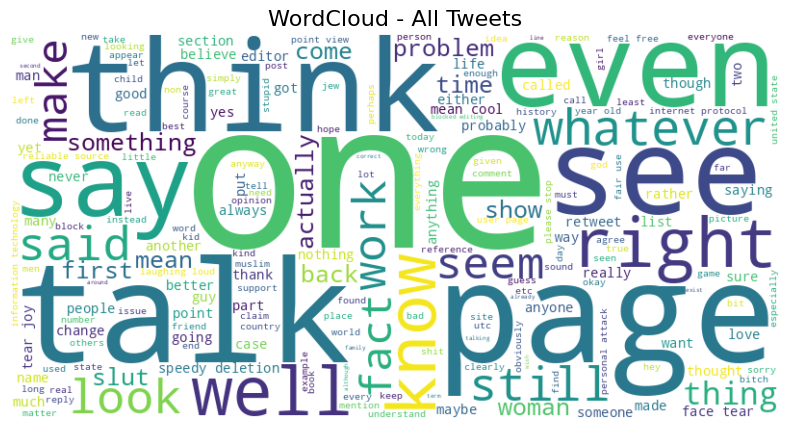

In [7]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine all text from a given subset
def generate_wordcloud(data, title):
    text = ' '.join(data.dropna().astype(str))
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16)
    plt.show()

# WordCloud for all data
generate_wordcloud(df['clean_text'], "WordCloud - All Tweets")

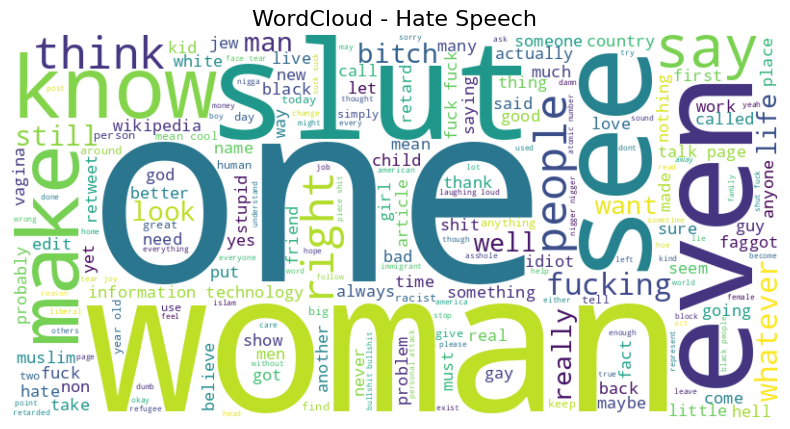

In [8]:
# WordCloud for hate speech (label == 1)
generate_wordcloud(df[df['label'] == 1]['clean_text'], "WordCloud - Hate Speech")

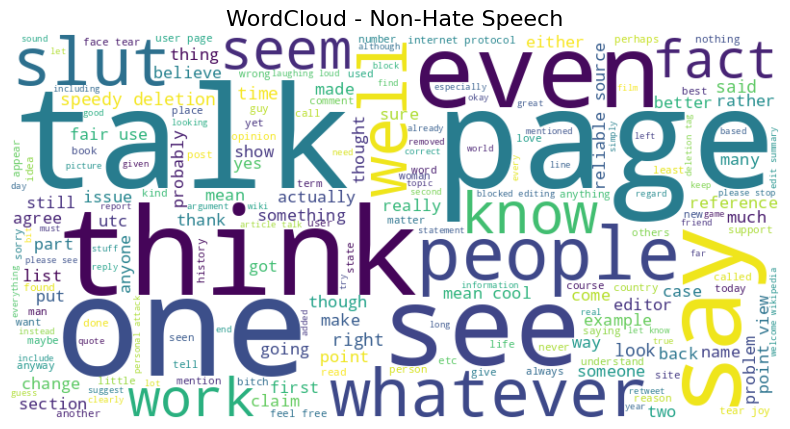

In [9]:
# WordCloud for non-hate (label == 0)
generate_wordcloud(df[df['label'] == 0]['clean_text'], "WordCloud - Non-Hate Speech")

**Analysis**

After seeing this word clouds,we get to know that some of these tweets/content are falsely labeled

So, Correcting those false labels is neccesary and we managed to it with help of a pretrained transformer model called **toxic-bert** , which will predict label for the corresponding tweet and we are using the predicted label as ground truth which will be durther used to train the models

In [ ]:
import pandas as pd
from transformers import pipeline
from tqdm import tqdm

# Initialize the HuggingFace hate speech classifier with GPU if available

classifier = pipeline(
    "text-classification",
    model="unitary/toxic-bert",
    device=0  # GPU
)
# Extract texts
texts = df['clean_text'].fillna("").tolist()

# Batch processing
batch_size = 32
results = []

for i in tqdm(range(0, len(texts), batch_size), desc="Classifying"):
    batch = texts[i:i+batch_size]
    try:
        outputs = classifier(batch, truncation=True)
        labels = [
            "Hate Speech" if out['label'].lower() in ['toxic', 'hate', 'hateful'] and out['score'] > 0.5
            else "Not Hate Speech"
            for out in outputs
        ]
    except Exception as e:
        print(f"⚠️ Error on batch {i}: {e}")
        labels = ["Error"] * len(batch)
    results.extend(labels)

# Add predictions to DataFrame
df['predicted_label'] = results

# Save the labeled dataset
df.to_csv("finalhatefull.csv", index=False)
print("✅ Saved as finalhatefull.csv")


Now we Have our proper cleaned dataset where tweets are labeled 'accurately' and also do not contain any null values

In [10]:
import pandas as pd

# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/HateSpeech/finalhatefull.csv')
df.head()

,old_label,clean_text,predicted_label
0,1,denial normal con asked comment tragedy emotio...,Hate Speech
1,1,able tweet insufferable bullshit prof trump na...,Hate Speech
2,1,retarded cute single life,Hate Speech
3,1,thought real badass mongol style declaration w...,Not Hate Speech
4,1,afro american basho,Not Hate Speech


In [11]:
# Map labels: 'Hate Speech' → 1, 'Not Hate Speech' → 0
df['predicted_label'] = df['predicted_label'].map({
    'Not Hate Speech': 0,
    'Hate Speech': 1
})

# Check the value counts
print(df['predicted_label'].value_counts())

predicted_label
0.0    458588
1.0    255522
Name: count, dtype: int64


In [12]:
# Drop rows where predicted_label is NaN
df = df.dropna(subset=['predicted_label'])

# Optional: make sure predicted_label is integer
df['predicted_label'] = df['predicted_label'].astype(int)


/tmp/ipython-input-12-30174606.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predicted_label'] = df['predicted_label'].astype(int)


In [13]:
df.drop(['old_label'], axis=1, inplace=True)

In [14]:
df = df.rename(columns={'predicted_label': 'label'})

In [15]:
df

,clean_text,label
0,denial normal con asked comment tragedy emotio...,1
1,able tweet insufferable bullshit prof trump na...,1
2,retarded cute single life,1
3,thought real badass mongol style declaration w...,0
4,afro american basho,0
...,...,...
714134,mute telecasting played kanye west clique know...,1
714135,hell yeah bachelor loooooooooooooooooooooooooo...,0
714136,great video musician musician lollllllllllllll...,0
714137,great pop video yeah pedophile yeah lollllllll...,1


In [16]:
print(df.columns)
print(df['label'].value_counts())  # Check class balance


Index(['clean_text', 'label'], dtype='object')
label
0    458588
1    255522
Name: count, dtype: int64


Now Also we Can see our word clouds, there will be a major change from the original dataset becuase the labels have changed so the word clouds will no differ

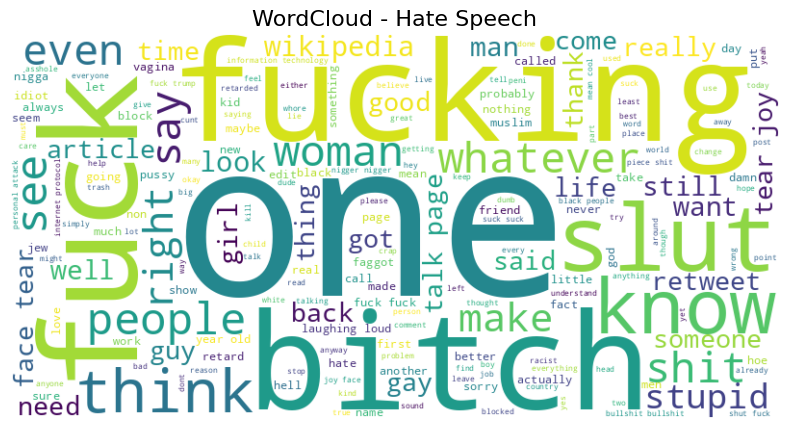

In [17]:
# WordCloud for hate speech (label == 1)
generate_wordcloud(df[df['label'] == 1]['clean_text'], "WordCloud - Hate Speech")

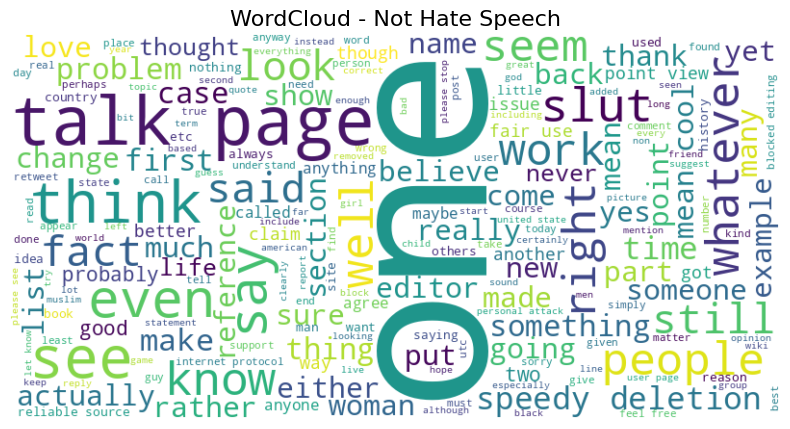

In [21]:
# WordCloud for hate speech (label == 0)
generate_wordcloud(df[df['label'] == 0]['clean_text'], "WordCloud - Not Hate Speech")

# **Pre-Processing**

Cleaning text, Removing stopwords, Emojis, URLs, unwanted symbols.

Lemmatization or Stemming, Tokenizing

# **Machine Learning Models**

Here we are going to work on Logistic Regression, Support Vector Machine(SVM), Naive Bayes(NB) and evaulate our machine learning models  and later compare performances among the ML models

**Dataset for ML models**

Splitting Into Train, Validation and Test Sets (70,15,15)

In [23]:
# Drop rows where predicted_label is NaN
df = df.dropna(subset=['label'])

# Optional: make sure predicted_label is integer
df['label'] = df['label'].astype(int)


In [24]:
from sklearn.model_selection import train_test_split

# First, split into train (70%) and temp (30%)
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df['clean_text'], df['label'],
    test_size=0.3, random_state=42, stratify=df['label']
)

# Now split temp into validation (15%) and test (15%)
val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels,
    test_size=0.5, random_state=42, stratify=temp_labels
)
print(f"Train size: {len(train_texts)}")
print(f"Validation size: {len(val_texts)}")
print(f"Test size: {len(test_texts)}")


Train size: 499877
Validation size: 107116
Test size: 107117


In [30]:
train_df = pd.DataFrame({'clean_text': train_texts, 'label': train_labels})
val_df = pd.DataFrame({'clean_text': val_texts, 'label': val_labels})
test_df = pd.DataFrame({'clean_text': test_texts, 'label': test_labels})

# Handle missing values
train_df['clean_text'] = train_df['clean_text'].fillna('')
val_df['clean_text'] = val_df['clean_text'].fillna('')
test_df['clean_text'] = test_df['clean_text'].fillna('')

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer
# You can customize parameters like max_features, ngram_range, etc.
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1,2))  # unigrams + bigrams

# Fit on training data and transform all splits
X_train = vectorizer.fit_transform(train_df['clean_text'])
X_val = vectorizer.transform(val_df['clean_text'])
X_test = vectorizer.transform(test_df['clean_text'])


In [32]:
y_train = train_df['label']
y_val = val_df['label']
y_test = test_df['label']


In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

def train_and_evaluate_model(model, X_train, y_train, X_val, y_val):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    acc = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)

    print(f"\n Model: {model.__class__.__name__}")
    print(f" Accuracy : {acc:.4f}")
    print(f" Precision: {precision:.4f}")
    print(f" Recall   : {recall:.4f}")
    print(f" F1 Score : {f1:.4f}")
    print("\n Full Classification:")
    print(classification_report(y_val, y_pred, digits=4))
    print("-" * 60)


In [34]:
models = [
    LogisticRegression(max_iter=1000),
    MultinomialNB(),
    LinearSVC()
]

for model in models:
    train_and_evaluate_model(model, X_train, y_train, X_val, y_val)



 Model: LogisticRegression
 Accuracy : 0.9408
 Precision: 0.9471
 Recall   : 0.8839
 F1 Score : 0.9144

 Full Classification:
              precision    recall  f1-score   support

           0     0.9376    0.9725    0.9548     68788
           1     0.9471    0.8839    0.9144     38328

    accuracy                         0.9408    107116
   macro avg     0.9424    0.9282    0.9346    107116
weighted avg     0.9410    0.9408    0.9403    107116

------------------------------------------------------------

 Model: MultinomialNB
 Accuracy : 0.8683
 Precision: 0.8298
 Recall   : 0.7950
 F1 Score : 0.8120

 Full Classification:
              precision    recall  f1-score   support

           0     0.8884    0.9091    0.8987     68788
           1     0.8298    0.7950    0.8120     38328

    accuracy                         0.8683    107116
   macro avg     0.8591    0.8521    0.8553    107116
weighted avg     0.8674    0.8683    0.8677    107116

------------------------------------

In [35]:
print(type(models))
print(models)


<class 'list'>
[LogisticRegression(max_iter=1000), MultinomialNB(), LinearSVC()]


Saving the ML models

In [36]:
import joblib

# Save the TF-IDF vectorizer
joblib.dump(vectorizer, 'tfidf_vectorizer.joblib')

# Save each model using its index in the list
joblib.dump(models[0], 'hs_logreg.joblib')       # Logistic Regression
joblib.dump(models[1], 'hs_naivebayes.joblib')   # Naive Bayes
joblib.dump(models[2], 'hs_svm.joblib')           # Support Vector Machine(SVM)

['hs_svm.joblib']

In [37]:
import joblib

# Load the vectorizer
vectorizer = joblib.load('tfidf_vectorizer.joblib')

# New comments to predict
new_comments = [
    "Have a wonderful day, everyone!",
    "what a piece of shit place.",
    "Thank you for your help!",
    "dumb ways to die",
    "i hate you",
    "i love you"
]

# Assume you have a clean_text function defined earlier
new_cleaned = [clean_text(text) for text in new_comments]
new_vectors = vectorizer.transform(new_cleaned)

# Mapping of model names to saved filenames
model_paths = {
    "Logistic Regression": 'hs_logreg.joblib',
    "Naive Bayes": 'hs_naivebayes.joblib',
    "SVM": 'hs_svm.joblib'
}

# Run predictions using each model
for model_name, file_path in model_paths.items():
    model = joblib.load(file_path)
    preds = model.predict(new_vectors)
    print(f"\n{model_name} Predictions:")
    for comment, pred in zip(new_comments, preds):
        label = "Hate Speech" if pred == 1 else "Not Hate"
        print(f"Comment: {comment}\nPrediction: {label}\n")
    print("-----------------------------------------------")



Logistic Regression Predictions:
Comment: Have a wonderful day, everyone!
Prediction: Not Hate

Comment: what a piece of shit place.
Prediction: Hate Speech

Comment: Thank you for your help!
Prediction: Not Hate

Comment: dumb ways to die
Prediction: Hate Speech

Comment: i hate you
Prediction: Hate Speech

Comment: i love you
Prediction: Not Hate

-----------------------------------------------

Naive Bayes Predictions:
Comment: Have a wonderful day, everyone!
Prediction: Not Hate

Comment: what a piece of shit place.
Prediction: Hate Speech

Comment: Thank you for your help!
Prediction: Not Hate

Comment: dumb ways to die
Prediction: Hate Speech

Comment: i hate you
Prediction: Hate Speech

Comment: i love you
Prediction: Not Hate

-----------------------------------------------

SVM Predictions:
Comment: Have a wonderful day, everyone!
Prediction: Not Hate

Comment: what a piece of shit place.
Prediction: Hate Speech

Comment: Thank you for your help!
Prediction: Not Hate

Comment

# **ML Model Evaluation & Comparision**


Model: Logistic Regression
Accuracy : 0.9408
Precision: 0.9471
Recall   : 0.8839
F1 Score : 0.9144

Validation Classification Report:
              precision    recall  f1-score   support

           0     0.9376    0.9725    0.9548     68788
           1     0.9471    0.8839    0.9144     38328

    accuracy                         0.9408    107116
   macro avg     0.9424    0.9282    0.9346    107116
weighted avg     0.9410    0.9408    0.9403    107116


Test Classification Report:
              precision    recall  f1-score   support

           0     0.9371    0.9712    0.9539     68788
           1     0.9447    0.8831    0.9128     38329

    accuracy                         0.9397    107117
   macro avg     0.9409    0.9271    0.9334    107117
weighted avg     0.9398    0.9397    0.9392    107117

------------------------------------------------------------

Model: Naive Bayes
Accuracy : 0.8683
Precision: 0.8298
Recall   : 0.7950
F1 Score : 0.8120

Validation Classification Re

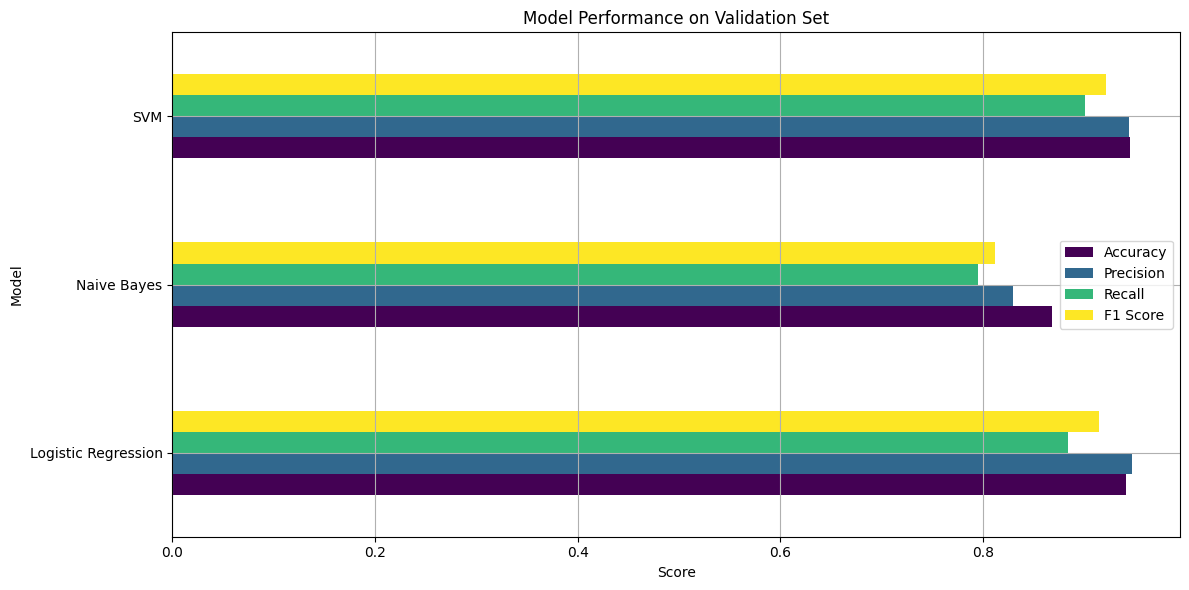

In [38]:
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Paths to your saved models
model_paths = {
    "Logistic Regression": "hs_logreg.joblib",
    "Naive Bayes": "hs_naivebayes.joblib",
    "SVM": "hs_svm.joblib"
}

# Result storage
results = {
    "Model": [],
    "Accuracy": [],
    "Precision": [],
    "Recall": [],
    "F1 Score": []
}

# Evaluation function
def evaluate_model(name, model, X_val, y_val, X_test, y_test):
    y_val_pred = model.predict(X_val)

    acc = accuracy_score(y_val, y_val_pred)
    precision = precision_score(y_val, y_val_pred)
    recall = recall_score(y_val, y_val_pred)
    f1 = f1_score(y_val, y_val_pred)

    results["Model"].append(name)
    results["Accuracy"].append(acc)
    results["Precision"].append(precision)
    results["Recall"].append(recall)
    results["F1 Score"].append(f1)

    print(f"\nModel: {name}")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall   : {recall:.4f}")
    print(f"F1 Score : {f1:.4f}")
    print("\nValidation Classification Report:")
    print(classification_report(y_val, y_val_pred, digits=4))

    # Evaluate on test set
    y_test_pred = model.predict(X_test)
    print("\nTest Classification Report:")
    print(classification_report(y_test, y_test_pred, digits=4))
    print("-" * 60)

# Evaluate all models
for name, path in model_paths.items():
    model = joblib.load(path)
    evaluate_model(name, model, X_val, y_val, X_test, y_test)

# Plot the comparison
df_results = pd.DataFrame(results).set_index("Model")
df_results.plot(kind='barh', figsize=(12, 6), colormap="viridis")
plt.title("Model Performance on Validation Set")
plt.xlabel("Score")
plt.grid(True)
plt.tight_layout()
plt.show()


# **Result & Conclusion (ML)**

As we saw above that ML models fails to capture context & give unsatisfactory reuslts and are inaccurate widely.


# **Deep Learning**

Now we will create embeddings using GloVe (which capture context in Global context in the corpus), we will then use this embeddings to train the DL model

In [39]:
import os
import urllib.request
import zipfile

# Download GloVe embeddings
if not os.path.exists('glove.6B.zip'):
    print("Downloading GloVe embeddings...")
    urllib.request.urlretrieve('http://nlp.stanford.edu/data/glove.6B.zip', 'glove.6B.zip')

# Unzip
if not os.path.exists('glove.6B.100d.txt'):
    print("Extracting GloVe embeddings...")
    with zipfile.ZipFile('glove.6B.zip', 'r') as zip_ref:
        zip_ref.extract('glove.6B.100d.txt')

print("GloVe embeddings ready.")


Extracting GloVe embeddings...
GloVe embeddings ready.


In [40]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout, Bidirectional, GlobalMaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from tqdm.keras import TqdmCallback

#  Clear any existing session
tf.keras.backend.clear_session()

#C print epoch number
class PrintEpochCallback(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        print(f"\Starting Epoch {epoch + 1}")

# Load and prepare dataset
df['clean_text'] = df['clean_text'].astype(str)


texts = df['clean_text'].tolist()
labels = df['label'].tolist()

# Tokenization
max_vocab_size = 20000
max_seq_len = 100
embedding_dim = 100  # GloVe 100D

tokenizer = Tokenizer(num_words=max_vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
padded_texts = pad_sequences(sequences, maxlen=max_seq_len, padding='post')

# Train/Val Split
X_train, X_val, y_train, y_val = train_test_split(
    padded_texts, labels, test_size=0.2, random_state=42, stratify=labels
)

# Load GloVe embeddings
embedding_index = {}
with open('glove.6B.100d.txt', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = vector

# Create Embedding Matrix
word_index = tokenizer.word_index
num_words = min(max_vocab_size, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, embedding_dim))

for word, idx in word_index.items():
    if idx >= max_vocab_size:
        continue
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[idx] = embedding_vector

# Build GRU Model
model = Sequential([
    Embedding(input_dim=num_words,
              output_dim=embedding_dim,
              weights=[embedding_matrix],
              input_length=max_seq_len,
              trainable=True),
    Bidirectional(GRU(128, return_sequences=True)),
    GlobalMaxPooling1D(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

# Callbacks
callbacks = [
    EarlyStopping(patience=2, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.5, patience=1),
    TqdmCallback(verbose=1),
    PrintEpochCallback()
]

# Training
history = model.fit(
    X_train, np.array(y_train),
    validation_data=(X_val, np.array(y_val)),
    epochs=10,
    batch_size=128,
    callbacks=callbacks,
    verbose=0
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     2,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,000,000 (7.63 MB)

 Trainable params: 2,000,000 (7.63 MB)

 Non-trainable params: 0 (0.00 B)

None


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

\Starting Epoch 1


KeyboardInterrupt: 

In [ ]:
# for saving the models
model.save("hs_gru.h5")
model.save("hs_gru.keras")
import pickle
with open('tokenizerpkl_gru.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

# **Evaluation the Deep Learning Model**

In [44]:
# Load the previously saved models, you can directly use this models instead of re running the above cells
# directly run this cell (do not run the above 2 cells if you have these model files)
from tensorflow.keras.models import load_model
model = load_model("/content/drive/MyDrive/Colab Notebooks/HateSpeech/hs_gru.h5")

import pickle
with open('/content/drive/MyDrive/Colab Notebooks/HateSpeech/tokenizerpkl_gru.pkl', 'rb') as f:
    tokenizer = pickle.load(f)

In [45]:
# Evaluate
val_loss, val_acc = model.evaluate(X_val, np.array(y_val))
print(f"\n Final Validation Accuracy: {val_acc:.4f}")

4464/4464 ━━━━━━━━━━━━━━━━━━━━ 288s 64ms/step - accuracy: 0.9581 - loss: 0.1012

 Final Validation Accuracy: 0.9580


In [48]:
def predict_hatespeech(text):
    sequence = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(sequence, maxlen=max_seq_len, padding='post')
    pred = model.predict(padded)[0][0]
    label = "Hate Speech" if pred > 0.5 else "Not Hate Speech"
    print(f"Text: {text}\nPrediction: {label} (Confidence: {pred:.4f})\n")


predict_hatespeech("dumb ways to die")
predict_hatespeech("you are such a loser")
predict_hatespeech("These people are disgusting and should go away.")
predict_hatespeech("what a dumb piece of shit")
predict_hatespeech("hey you immigrant , get the heck out")
predict_hatespeech("your are so nice")
predict_hatespeech("i do not like the govt, they are going to ruin this country")
predict_hatespeech("lionel messi is the goat of football")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
Text: dumb ways to die
Prediction: Hate Speech (Confidence: 0.9999)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
Text: you are such a loser
Prediction: Hate Speech (Confidence: 0.9179)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
Text: These people are disgusting and should go away.
Prediction: Hate Speech (Confidence: 0.8697)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
Text: what a dumb piece of shit
Prediction: Hate Speech (Confidence: 1.0000)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
Text: hey you immigrant , get the heck out
Prediction: Hate Speech (Confidence: 0.5032)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
Text: your are so nice
Prediction: Not Hate Speech (Confidence: 0.0431)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
Text: i do not like the govt, they are going to ruin this country
Prediction: Not Hate Speech (Confidence: 0.4539)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
Text: lionel messi is the goat of football
Prediction: Not Hate Speech (Confidence: 0.1393

The Deep learning models is quite accurate and is able to capture context, but fails to capture sarcasm, certain tones.
Now we we will use Pretrained Models(these are transformers which hasve been trained on millions of Bytes of Data and perform well in general)

# **Pre-Trained Transformers**

In [58]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import torch
import pickle

# Load GRU model and tokenizer
gru_model = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/HateSpeech/hs_gru.h5")
with open("/content/drive/MyDrive/Colab Notebooks/HateSpeech/tokenizerpkl_gru.pkl", "rb") as f:
    gru_tokenizer = pickle.load(f)
gru_maxlen = 100

# Load Hugging Face models
model_hf_1 = "facebook/roberta-hate-speech-dynabench-r4-target"
model_hf_2 = "tomh/toxigen_roberta"

tokenizer_1 = AutoTokenizer.from_pretrained(model_hf_1)
model_1 = AutoModelForSequenceClassification.from_pretrained(model_hf_1)

tokenizer_2 = AutoTokenizer.from_pretrained(model_hf_2)
model_2 = AutoModelForSequenceClassification.from_pretrained(model_hf_2)

# Weights for ensemble
w_gru = 0.3
w_roberta = 0.4
w_tbert = 0.3

def predict_ensemble(text):
    # GRU prediction
    seq = gru_tokenizer.texts_to_sequences([text])
    padded = pad_sequences(seq, maxlen=gru_maxlen, padding='post')
    gru_prob = gru_model.predict(padded, verbose=0)[0][0]  # Suppress verbose output

    # facebook/RoBERTa prediction
    inputs_1 = tokenizer_1(text, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        logits_1 = model_1(**inputs_1).logits
        probs_1 = torch.nn.functional.softmax(logits_1, dim=1)
        roberta_prob = probs_1[0][1].item()

    # toxigen-roberta prediction
    inputs_2 = tokenizer_2(text, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        logits_2 = model_2(**inputs_2).logits
        probs_2 = torch.nn.functional.softmax(logits_2, dim=1)
        tbert_prob = probs_2[0][1].item()

    # Weighted average
    final_score = (0.3 * gru_prob) + (0.4 * roberta_prob) + (0.4 * tbert_prob)
    label = "Hate Speech" if final_score > 0.5 else "Not Hate Speech"

    return {
        "text": text,
        "gru_prob": round(gru_prob, 4),
        "roberta_prob": round(roberta_prob, 4),
        "tbert_prob": round(tbert_prob, 4),
        "final_score": round(final_score, 4),
        "prediction": label
    }


In [59]:
def predict_with_confidences(text):
    # GRU prediction (sigmoid single-output)
    seq = gru_tokenizer.texts_to_sequences([text])
    padded = pad_sequences(seq, maxlen=gru_maxlen, padding='post')
    gru_hate = float(gru_model.predict(padded)[0][0])
    gru_probs = {
        "not_hate": round(1 - gru_hate, 4),
        "hate":      round(gru_hate, 4)
    }

    # facebook/RoBERTa prediction (softmax two-output)
    inputs_1 = tokenizer_1(text, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        logits_1 = model_1(**inputs_1).logits
        probs_1 = torch.nn.functional.softmax(logits_1, dim=1)[0].cpu().numpy()
    roberta_probs = {
        "not_hate": round(float(probs_1[0]), 4),
        "hate":     round(float(probs_1[1]), 4)
    }

    # toxic-roberta prediction (softmax two-output)
    inputs_2 = tokenizer_2(text, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        logits_2 = model_2(**inputs_2).logits
        probs_2 = torch.nn.functional.softmax(logits_2, dim=1)[0].cpu().numpy()
    tbert_probs = {
        "not_hate": round(float(probs_2[0]), 4),
        "hate":     round(float(probs_2[1]), 4)
    }

    # Weighted ensemble (on the hate class only)
    final_hate_score = (
        0.3  * gru_probs["hate"] +
        0.4 * roberta_probs["hate"] +
        0.3 * tbert_probs["hate"]
    )
    final_label = "Hate Speech" if final_hate_score > 0.5 else "Not Hate Speech"

    return {
        "text": text,
        "gru_probs":       gru_probs,
        "roberta_probs":    roberta_probs,
        "tbert_probs": tbert_probs,
        "final_hate_score": round(final_hate_score, 4),
        "prediction":       final_label
}

In [60]:
example = "hey you immigrant, get the heck out of here"
res = predict_with_confidences(example)

print(f"Input text: {res['text']}\n")

print("GRU model probabilities:")
print(f"  • Not Hate: {res['gru_probs']['not_hate']}")
print(f"  • Hate:     {res['gru_probs']['hate']}\n")

print("facebook/RoBERTa model probabilities:")
print(f"  • Not Hate: {res['roberta_probs']['not_hate']}")
print(f"  • Hate:     {res['roberta_probs']['hate']}\n")

print("Toxigen-roberta model probabilities:")
print(f"  • Not Hate: {res['tbert_probs']['not_hate']}")
print(f"  • Hate:     {res['tbert_probs']['hate']}\n")

print(f"Ensemble hate score: {res['final_hate_score']}")
print(f"Final prediction:   {res['prediction']}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 819ms/step
Input text: hey you immigrant, get the heck out of here

GRU model probabilities:
  • Not Hate: 0.5003
  • Hate:     0.4997

facebook/RoBERTa model probabilities:
  • Not Hate: 0.0002
  • Hate:     0.9998

Toxigen-roberta model probabilities:
  • Not Hate: 0.0088
  • Hate:     0.9912

Ensemble hate score: 0.8472
Final prediction:   Hate Speech
